# Explain the GNN predictions

## 0. Preparations
### Imports

In [1]:
from pathlib import Path
import pickle

import numpy as np
from numpy import (
    newaxis,
)  # This is just an alias for None and makes the code more readable when adding a new dimension to a Tensor
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange
import torch
import torch.nn.functional as F
from torch_geometric.explain import Explainer, AttentionExplainer, Explanation # Change: Use the AttentionExplainer provided by PyG (https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.explain.algorithm.AttentionExplainer.html#torch_geometric.explain.algorithm.AttentionExplainer)
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.data import Data
from torch_geometric.nn.models import GAT # Change: Only works with GNNs that use attention so we need to switch to the Graph Attention Network (GAT: https://arxiv.org/pdf/1710.10903.pdf) or something similar. 

# Snippets from my Master Thesis repository so that the non-relevant parts of the code are as short as possible
from src.data_loading import get_spatial_data
from src.graph_construction import build_radius_delaunay_graph

### Check for GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Define a Random Number Generator

In [3]:
rng = torch.Generator()
rng.manual_seed(42)

## 1. Graph Construction and Model Training

### Define Hyperparameters

The hyperparameters are all chosen according to the results of the evaluation that is the main part of the thesis.

In [4]:
# For graph construction (Radius Delanay)
graph_construction_radius = 0.00018225
self_loops = False  # Self-Loops will not be used since we want to minimize the effect of the gene expression profile of the node itself
edge_weights = False
train_frac = 0.8  # The fraction of nodes that should be used for training. It will be assigned randomly and the rest will be used for testing.

# Changed accordingly:
# For the GNN model (GAT)
num_layers = 2
hidden_channels = 128
activation = "relu"
dropout_rate = 0.2
num_attention_heads = 8

# For the training algorithm (Adam)
lr = 0.01
weight_decay = 1e-5
n_epochs = 45

# For the Explainer
repeats = 10

### Load Data

In [5]:
cells, genes = get_spatial_data("intestine")

cell_coordinates = cells[["x", "y"]].values
features = genes.values
true_labels = cells["cluster_id"].values
ordered_names = (
    cells[["cluster_id", "cell_type"]].drop_duplicates().set_index("cluster_id").sort_index()["cell_type"].values
)

print("Cell coordinates: ", cell_coordinates.shape)
print("Features: ", features.shape)
print("True labels: ", true_labels.shape)  # Must be 1D array!

Cell coordinates:  (7416, 2)
Features:  (7416, 241)
True labels:  (7416,)


### Construct Radius-Delaunay Graph

This is the overall best performing graph construction method so we will use it for the following. This step is deterministic so we do not need to repeat it multiple times and we can just do it once and then use the constructed graph.

In [6]:
graph = build_radius_delaunay_graph(
    positions=cell_coordinates,
    radius=graph_construction_radius,
    include_self_loops=self_loops,
    add_distance=edge_weights,
    features=features,
    labels=true_labels,
    library="pyg", # The only available option since the code snippet is not the complete version of the normal code
)

num_labels = len(np.unique(true_labels))
num_nodes = graph.num_nodes
num_edges = graph.num_edges

print("Number of labels:", num_labels)
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)
print("Average degree:", num_edges / num_nodes)

Number of labels: 19
Number of nodes: 7416
Number of edges: 32636
Average degree: 4.400755124056095


### Train/Test Split

Since we are not changing any hyperparameter and are not really interested in the performance of the model itself, we will omit the validation set and just use the test set for evaluation.

In [7]:
def assign_random_splits(graph: Data) -> Data:
    """Takes the generated PyG graph as input and assigns a mask for the train and test split that is used for training and evaluation. The PyG graph will be returned with the assigned split."""
    graph = graph.clone()
    random_indices = torch.randperm(num_nodes, generator=rng)

    train_indices = random_indices[: int(num_nodes * train_frac)]
    test_indices = random_indices[int(num_nodes * train_frac) :]

    # Not all datatypes are allowed for the index: Only bool, byte or long
    graph.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    graph.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    graph.train_mask[train_indices] = 1
    graph.test_mask[test_indices] = 1
    return graph

In [8]:
# The configurations chosen in the following are chosen as the overall best after the main grid search
def train_model(graph: Data) -> tuple[GAT, Data]:
    """Initializes and trains the model"""
    model = GAT(
        in_channels=features.shape[1],
        out_channels=num_labels,
        hidden_channels=hidden_channels,
        num_layers=num_layers,
        dropout=dropout_rate,
        act=activation,
        jk="last",  # This adds a final linear layer after the GNN layers
        # arguments that are passed to the Convolutional layer; Changed accordingly...
        heads=num_attention_heads,
        concat=True,
        negative_slope=0.2,
        add_self_loops=False,
        edge_dim=None,
        bias=True,
    )

    # Move model to the correct device memory. Needed for training on the GPU.
    model = model.to(device)

    graph = assign_random_splits(graph)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop
    for _ in range(1, n_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(graph.x, graph.edge_index)
        loss = F.cross_entropy(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()

    # Test the model
    pred = model(graph.x, graph.edge_index).argmax(dim=-1)
    acc = int((pred[graph.test_mask] == graph.y[graph.test_mask]).sum()) / int(graph.test_mask.sum())
    print(f"Finished training with an accuracy of {acc:.4f} for the test set")

    return model, graph

## 2. Explainability

With the explainability framework that is implemented in [Pytorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/explain.html), it is very easy to try out different explainability methods. According to the overview paper "[GraphFramEx: Towards Systematic Evaluation of Explainability Methods for Graph Neural Networks](https://arxiv.org/abs/2206.09677)" that is the basis for the PyG implementation, the saliency map method works best overall. We will therefore use this method for the following.

The `Explainer` class that will be used takes a few arguments: First, the trained model that should be explained. We will use the model and training loop defined above. Second, the algorithm which will be the saliency maps for now. Next, an explanation type as there are two different variants. Since I am not yet familiar with the theory behind the method, I do not know what the difference is. In a [blog post](https://medium.com/@pytorch_geometric/graph-machine-learning-explainability-with-pyg-ff13cffc23c2) by PyG used as introduction to this framework it is explained as follows:

- *`explanation_type="phenomenon"` aims to explain why a certain decision was made for a particular input. We are interested in the phenomenon that leads from inputs to outputs in our data. In this case the labels are used as targets for the explanation.*
- *`explanation_type="model"` aims to provide a post-hoc explanation for the model provided. In this setting we are trying to open the black-box and explain the logic behind it. In this case the model predictions are used as targets for the explanation.*

As far as I understand it, we are more interested in the `phenomenon` variant but we will probably need a thorough evaluation of both to see which is best. The next two arguments define the output type of the explanation. 
![Output visualization](img/GNN_Explainability_A.png)

As we can see in the image above, the algorithm decides the importance for every node but also for every edge and even for every input dimension (the genes in our case). It is given as two arrays that contain the importance as float for every node and edge at the corresponding index of the node or edge in the graph representation. The explanations for each can be given as three different types but are sometimes limited to the algorithm used (The saliency map approach works only with the configured options):

![Mask types](img/explanation_type.webp)

As visualized here, the three options are either one importance value for each node (per cell), one value for each feature dimension shared across every node (per gene) or one value for each node and feature dimension (per cell and gene). The last argument configure the specifics for the model. If the outputs are class probabilities or logits, what type of task and so on...

### Initialize Explainer
For a better overview, the following function will be used to initialize the explainer for each trained model with the arguments as explained above:

In [9]:
def init_explainer(model: GAT) -> Explainer:
    return Explainer(
        model,
        algorithm=AttentionExplainer(),
        explanation_type="model",
        node_mask_type=None,
        edge_mask_type="object",
        model_config=dict(
            mode="multiclass_classification",
            task_level="node",
            return_type="raw",
        ),
    )

### Aggregate Explanations

The explanation can be made for the prediction of every node and returns importance values for every node and feature and edge in the graph. This needs a lot of memory so we will not save everything but just aggregate what we are interested in. For this task, we will define a class with a total of five different aggregations that are done while predicting and explaining each node: 

- **Neighbor**: This counts the number of neighbors of a specific cell type for each node and is used as a baseline
- **Impotant direct neighbor count**: This counts the number of direct neighbors of each cell type that have an importance value larger than zero for each node
- **Important 2-hop neighbor count**: This counts the number of 2-hop neighbors of each cell type that have an importance value larger than zero for each node
- **Importance sum**: This sums up the importance values for each cell type of all predictions
- **Importance sum per feature**: This sums up the importance values for each cell type for each node and feature

All but the last one result in a matrix of shape `(number of cell types, number of cell types)` where the y-axis represents the cell type of the ground truth and the x-axis the cell type of the important neighbors that influence the result. The last one is extended by another dimension for the features. All matrices are gathered repeatedly and then saved as tensors where the 0th dimension is the number of repeats.

In [10]:
class ExplanationAggregator:
    def __init__(self, graph: Data) -> None:
        self.graph = graph
        self.neighbor_matrices = torch.zeros((repeats, num_labels, num_labels), device=device)
        self.count_matrices = torch.zeros((repeats, num_labels, num_labels), device=device)
        self.count_2hop_matrices = torch.zeros((repeats, num_labels, num_labels), device=device)
        self.sum_matrices = torch.zeros((repeats, num_labels, num_labels), device=device)
        self.cell_type_gene_matrices = torch.zeros((repeats, num_labels, num_labels, features.shape[1]), device=device)

    def __call__(self, explanation: Explanation, repeat: int, pred_cell_type_idx: int, node_idx: torch.Tensor) -> None:
        neighbors = self.get_neighbors(node_idx)
        important_nodes = self.get_important_nodes(explanation)
        # Count the cell types for each neighbor to have a baseline
        self.count_neighboring_cell_types(repeat, pred_cell_type_idx, neighbors)
        self.count_important_direct_neighbors(repeat, pred_cell_type_idx, neighbors, important_nodes)
        self.count_important_2hop_neighbors(repeat, pred_cell_type_idx, neighbors, important_nodes)
        self.sum_importance(explanation, repeat, pred_cell_type_idx)
        # self.sum_importance_per_feature(explanation, repeat, pred_cell_type_idx)

    def get_neighbors(self, node_idx: torch.Tensor) -> torch.Tensor:
        neighbors, _, _, _ = k_hop_subgraph(node_idx[newaxis], num_hops=1, edge_index=self.graph.edge_index)
        return neighbors

    def get_important_nodes(self, explanation: Explanation) -> torch.Tensor:
        # important_nodes = torch.unique(torch.nonzero(explanation.node_mask)[:, 0])
        important_nodes = torch.unique(self.graph.edge_index[:, torch.nonzero(explanation.edge_mask)]) # Does the same as the above but is slower
        return important_nodes

    def count_neighboring_cell_types(self, repeat: int, pred_cell_type_idx: int, neighbors: torch.Tensor):
        # Find the cell type label for each neighbor
        cell_type_labels = self.graph.y[neighbors]
        # Count the occurence of each cell type label
        neighbor_ids, counts = torch.unique(cell_type_labels, return_counts=True)
        # Add the occurences to the corresponding matrix
        self.neighbor_matrices[repeat][pred_cell_type_idx, neighbor_ids] += counts

    def count_important_direct_neighbors(
        self, repeat: int, pred_cell_type_idx: int, neighbors: torch.Tensor, important_nodes: torch.Tensor
    ):
        # Calculate intersection between neighbors and the important nodes to see which of the nodes are direct neighbors
        important_neighbors = important_nodes[torch.isin(important_nodes, neighbors, assume_unique=True)]
        # Find the cell type label for each neighbor
        cell_type_labels = self.graph.y[important_neighbors]
        # Count the occurence of each cell type label and add the occurences to the corresponding matrix
        unique_ids, counts = torch.unique(cell_type_labels, return_counts=True)
        self.count_matrices[repeat][pred_cell_type_idx, unique_ids] += counts

    def count_important_2hop_neighbors(
        self, repeat: int, pred_cell_type_idx: int, neighbors: torch.Tensor, important_nodes: torch.Tensor
    ):
        # Calculate difference between neighbors and the important nodes to see which of the nodes are indirect neighbors
        important_2hop_neighbors = important_nodes[~torch.isin(important_nodes, neighbors, assume_unique=True)]
        # Find the cell type label for each neighbor
        cell_type_labels = self.graph.y[important_2hop_neighbors]
        # Count the occurence of each cell type label and add the occurences to the corresponding matrix
        unique_ids, counts = torch.unique(cell_type_labels, return_counts=True)
        self.count_2hop_matrices[repeat][pred_cell_type_idx, unique_ids] += counts

    def sum_importance(self, explanation: Explanation, repeat: int, pred_cell_type_idx: int):
        # Sum up the influence for each cell type pair
        # Currently not divided into direct neighbors and 2 hop neighbors
        self.sum_matrices[repeat][pred_cell_type_idx] = self.sum_matrices[repeat][pred_cell_type_idx].index_add(
            0,
            self.graph.y[self.graph.edge_index[0, torch.nonzero(explanation.edge_mask)]].reshape(-1),
            explanation.edge_mask[torch.nonzero(explanation.edge_mask)].reshape(-1),
        )
        # There are some problems with NaN values here so they are set to 0
        self.sum_matrices[repeat][pred_cell_type_idx] = torch.nan_to_num(self.sum_matrices[repeat][pred_cell_type_idx])

    # Not possible with the attention scores
    # def sum_importance_per_feature(self, explanation: Explanation, repeat: int, pred_cell_type_idx: int):
    #     # Sum up the influence of each gene for predicting each type
    #     self.cell_type_gene_matrices[repeat][pred_cell_type_idx] = self.cell_type_gene_matrices[repeat][
    #         pred_cell_type_idx
    #     ].index_add(0, self.graph.y, explanation.node_mask)

    def save(self):
        self.save_file("neighbor_matrices", self.neighbor_matrices)
        self.save_file("count_matrices", self.count_matrices)
        self.save_file("count_2hop_matrices", self.count_2hop_matrices)
        self.save_file("sum_matrices", self.sum_matrices)
        # self.save_file("cell_type_gene_matrices", self.cell_type_gene_matrices)

    def save_file(self, filename: str, matrices: torch.Tensor):
        with open(f"results/{filename}.pkl", "wb") as f:
            pickle.dump(matrices, f)

    def check_for_saved_results(self) -> bool:
        parent_path = Path("results")
        res = True
        if parent_path.exists() and parent_path.is_dir():
            for path in [
                "neighbor_matrices",
                "count_matrices",
                "count_2hop_matrices",
                "sum_matrices",
                # "cell_type_gene_matrices",
            ]:
                if not (parent_path / f"{path}.pkl").exists():
                    res = False
        else:
            res = False
        return res

    def load(self):
        if self.check_for_saved_results():
            self.neighbor_matrices = self.load_file("neighbor_matrices")
            self.count_matrices = self.load_file("count_matrices")
            self.count_2hop_matrices = self.load_file("count_2hop_matrices")
            self.sum_matrices = self.load_file("sum_matrices")
            # self.cell_type_gene_matrices = self.load_file("cell_type_gene_matrices")

    def load_file(self, file_name: str) -> torch.Tensor:
        with open(f"results/{file_name}.pkl", "rb") as f:
            matrices = pickle.load(f)
        matrices = matrices.to(device)
        return matrices

### Run everything

Now we can run everything if the results are not already saved:

In [11]:
graph = graph.to(device)
gatherer = ExplanationAggregator(graph)

if gatherer.check_for_saved_results():
    gatherer.load()
else:
    # The importance values seem to have a high variance so we repeat the whole procedure multiple times
    for k in trange(repeats):
        model, curr_graph = train_model(graph)

        for i in range(num_labels):
            for j in torch.where(graph.y == i)[0]:
                explainer = init_explainer(
                    model
                )  # Needs to be initialized new everytime. Exception is thrown otherwise
                # Apparently, the AttentionExplainer cannot handle tensors with zero dimension so we add another dimension
                explanation = explainer(x=curr_graph.x, edge_index=curr_graph.edge_index, index=j[newaxis])
                gatherer(explanation, repeat=k, pred_cell_type_idx=i, node_idx=j)

    gatherer.save()

  0%|          | 0/10 [00:00<?, ?it/s]

Finished training with an accuracy of 0.7311 for the test set
Finished training with an accuracy of 0.7358 for the test set
Finished training with an accuracy of 0.7257 for the test set
Finished training with an accuracy of 0.7197 for the test set
Finished training with an accuracy of 0.7446 for the test set
Finished training with an accuracy of 0.7170 for the test set
Finished training with an accuracy of 0.7075 for the test set
Finished training with an accuracy of 0.7049 for the test set
Finished training with an accuracy of 0.7446 for the test set
Finished training with an accuracy of 0.7069 for the test set


### Check if the method is reliable

In [12]:
avg_neighbor_matrix = gatherer.neighbor_matrices.mean(dim=0).cpu()
avg_count_matrix = gatherer.count_matrices.mean(dim=0).cpu()
avg_count_2hop_matrix = gatherer.count_2hop_matrices.mean(dim=0).cpu()
avg_sum_matrix = gatherer.sum_matrices.mean(dim=0).cpu()
# avg_cell_type_gene_matrix = gatherer.cell_type_gene_matrices.mean(dim=0).cpu()

std_neighbor_matrix = gatherer.neighbor_matrices.std(dim=0).cpu()
std_count_matrix = gatherer.count_matrices.std(dim=0).cpu()
std_count_2hop_matrix = gatherer.count_2hop_matrices.std(dim=0).cpu()
std_sum_matrix = gatherer.sum_matrices.std(dim=0).cpu()
# std_cell_type_gene_matrix = gatherer.cell_type_gene_matrices.std(dim=0).cpu()

### Neighbor distribution as baseline

<Axes: >

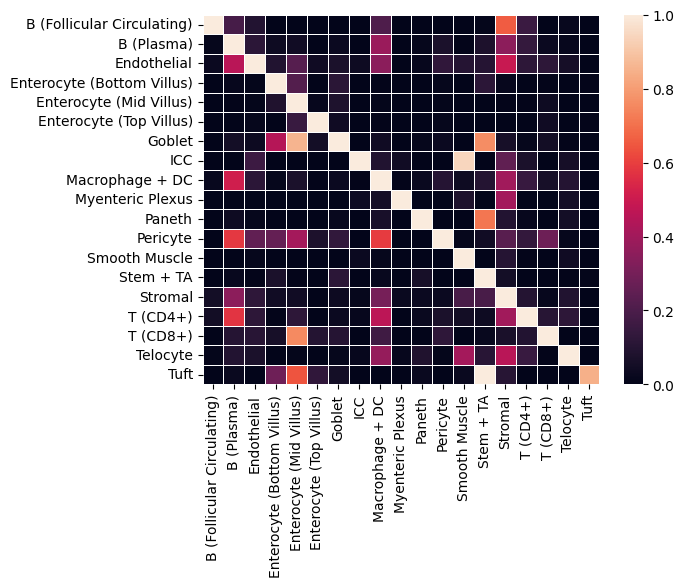

In [13]:
sns.heatmap(
    F.normalize(avg_neighbor_matrix, p=float("inf"), dim=1),
    xticklabels=ordered_names,
    yticklabels=ordered_names,
    linewidth=0.5,
)

#### Heatmap showing the influence of each cell type for the prediction of each cell type by counting the number of direct neighbors that have any influence > 0

For the next three plots, the prediction target is on the y-axis and the neighboring cell types that influence the prediction are on the x-axis.

Maximal average: 7187.0
Maximal standard deviation at: 0.0
Average average: 110.82548522949219
Average standard deviation at: 0.0


<Axes: >

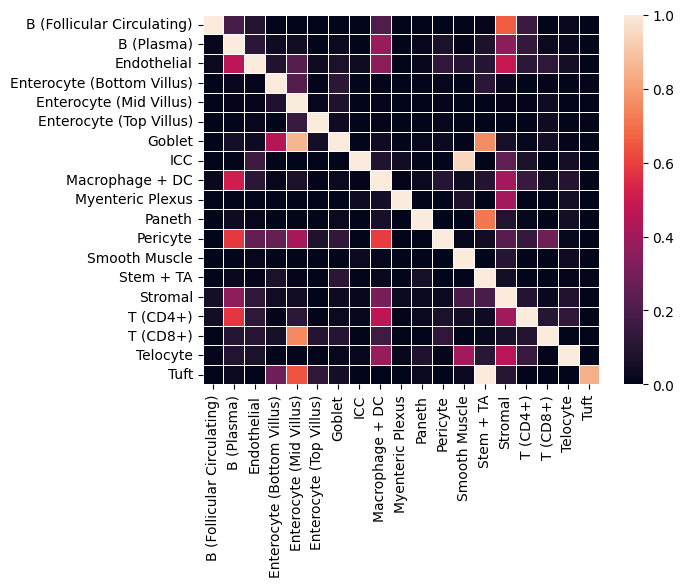

In [14]:
print(f"Maximal average: {avg_count_matrix.max()}")
print(f"Maximal standard deviation at: {std_count_matrix.max()}")
print(f"Average average: {avg_count_matrix.mean()}")
print(f"Average standard deviation at: {std_count_matrix.mean()}")

sns.heatmap(
    F.normalize(avg_count_matrix, p=float("inf"), dim=1),
    xticklabels=ordered_names,
    yticklabels=ordered_names,
    linewidth=0.5,
)

#### Same as above for second order neighbors

Maximal average: 8912.0
Maximal standard deviation at: 0.0
Average average: 162.69805908203125
Average standard deviation at: 0.0


<Axes: >

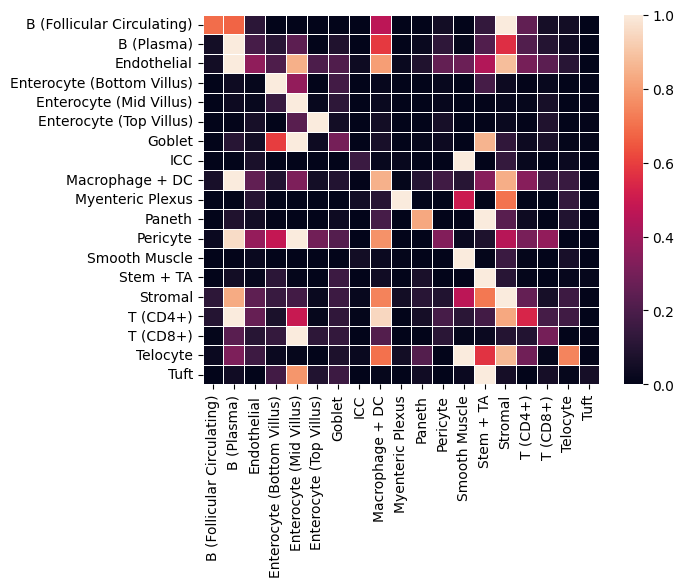

In [15]:
print(f"Maximal average: {avg_count_2hop_matrix.max()}")
print(f"Maximal standard deviation at: {std_count_2hop_matrix.max()}")
print(f"Average average: {avg_count_2hop_matrix.mean()}")
print(f"Average standard deviation at: {std_count_2hop_matrix.mean()}")
sns.heatmap(
    F.normalize(avg_count_2hop_matrix, p=float("inf"), dim=1),
    xticklabels=ordered_names,
    yticklabels=ordered_names,
    linewidth=0.5,
)

#### The influence values for all direct and 2nd order neighbors summed up

Maximal average: 29538.0
Maximal standard deviation at: 3432.61962890625
Average average: 522.478271484375
Average standard deviation at: 78.317138671875


<Axes: >

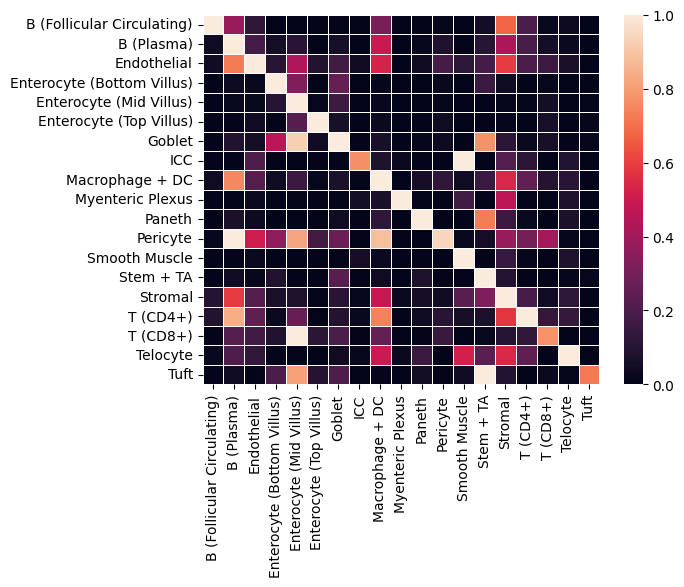

In [16]:
print(f"Maximal average: {avg_sum_matrix.max()}")
print(f"Maximal standard deviation at: {std_sum_matrix.max()}")
print(f"Average average: {avg_sum_matrix.mean()}")
print(f"Average standard deviation at: {std_sum_matrix.mean()}")
sns.heatmap(
    F.normalize(avg_sum_matrix, p=float("inf"), dim=1),
    xticklabels=ordered_names,
    yticklabels=ordered_names,
    linewidth=0.5,
)

#### **Not possible:** The influence of each gene per cell type for the cell type: *B (Plasma)*

Here, the whole plot corresponds to a single prediction target and the y-axis is the influence of each cell type while the x-axis is the influence of each gene.

In [17]:
# print(f"Maximal average: {avg_cell_type_gene_matrix[1].max()}")
# print(f"Maximal standard deviation at: {std_cell_type_gene_matrix[1].max()}")
# print(f"Average average: {avg_cell_type_gene_matrix[1].mean()}")
# print(f"Average standard deviation at: {std_cell_type_gene_matrix[1].mean()}")

# sns.heatmap(avg_cell_type_gene_matrix[1].T, xticklabels=ordered_names, vmax=5)